# Parallelism with Dask

The dask folks have a very good introduction to dask data structures and parallelism in their
[dask tutorial](https://tutorial.dask.org/).  In that tutorial, you'll get exposure to 
the general dask architecture, as well as specific hands-on examples with two of the three
key dask data structures:  dask arrays, and dask dataframes. 

The above tutorial does not cover dask `bag` in any detail -- this is a key data structure
that we use to distribute parallel tasks in clustered environments.  Here's a quick demo of 
a dask bag and how we use it. 


## Lists and Maps

A common pattern in Python is a 'list comprehension' -- a way of transforming a list of values into a new list of values using a transformation pattern.

In [1]:
myList = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

newList = [x**2 for x in myList]

newList

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

This feature of python **maps** an action onto each element in a list. The result is a new list
holding the result of each action.  The syntax of the above list comprehension is purely for us
humans... the python implementation behind the scenes uses a special built-in python function called `map`:

In [2]:
def myFunc(i):
    return i**2

list(map(myFunc, myList))
# maps each element of myList to a separate invokation of myFunc. 

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

You can see that doing it this way involves a lot of extra hoops and parenthesis to jump through.. which is why it is almost never written that way.  

The `myFunc()` function is called several times, once for each element in `myList`. The list element is given to the function as a positional argument.  In essence, the above `map` is the same as: 



In [3]:
result=[]
for x in myList:
    result.append(myFunc(x))
result

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

## Dask Bag

A dask bag datastructure is much like a list, but it has the `map` function built into it as an object method. The invocation is slightly different, and it has the ability to spawn the `myFunc()` calls in parallel, distributing those calls to workers around the dask cluster. 

Let's look at an example... first, let's make `myFunc()` simulate time-consuming work by having it pause for a while. 

In [4]:
from time import sleep
def myFunc(i):
    sleep(1) ## Simulates dense computation taking one second
    return i**2

This function is one that we want to distribute across a dask compute cluster...

:::{sidebar}
For a primer on cluster configuration, see [here](Parallel_Clusters.md)
:::


In [5]:
import os
import dask.bag as db

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(threads_per_worker=os.cpu_count())
client = Client(cluster)

In [6]:
# fill the bag with our list of items
myBag = db.from_sequence(myList)
result = myBag.map(myFunc)

Note that this returned immediately. That's because the computation has not been called yet. 

As with other dask operations, `result` at this point just contains the task graph -- what dask is going to do, and in what order. 

Visulalize the task graph:

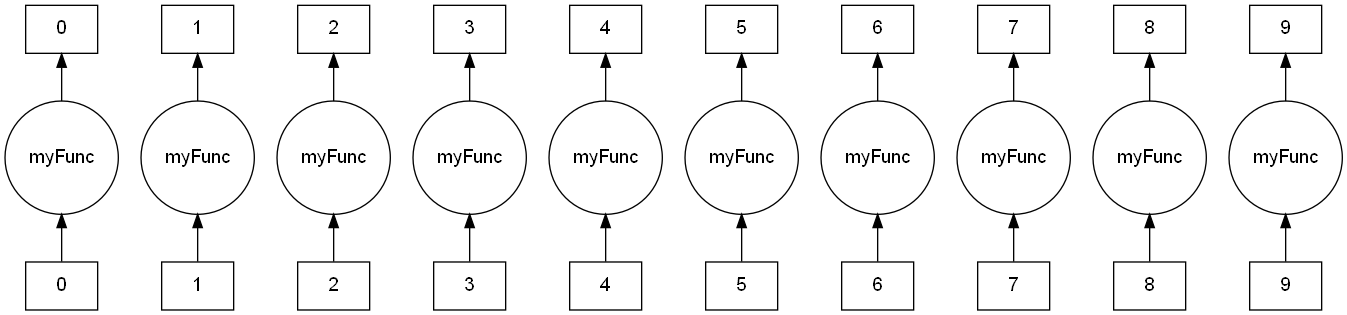

In [7]:
result.visualize()

Note that each of those elements is independent from the others, so they can in theory execute in parallel. In the original, pure-python operation, these calls to `myFunc` would be serialized. 

Let's compare:


In [8]:
%%time
## Pure python mapping:
list( map( myFunc, myList))

CPU times: total: 172 ms
Wall time: 10.1 s


[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

In [9]:
%%time
## using the dask bag task-graph
result.compute()

CPU times: total: 688 ms
Wall time: 2.73 s


[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

Note that the pure python execution took right around 10 seconds.  Each call to `myFunc`, remember, is artificially set to take one second each.  Calling them serially should take 10 seconds (plus whatever internal overhead python needs). 

The dask bag approach took substantially less time. If it were **perfectly** parallel, the result would have been computed in one second (ten simultaneous executions of `myFunc`, each taking one second).  But that parallelism depends on how many cpus/cores you have.  If you only have one core, then parallelism isn't going to help  you -- the dispatched workers still need to take turns on the CPU.  

If you had 10 cores (the number of elements in the bag), then you might get close to the perfect parallelism.  Dask does involve more overhead than pure python in order to achieve its parallelism; the administrative overhead for operating the cluster scheduler will prevent this from being perfectly parallel. 

The above example uses a **local** cluster, meaning that the work is scheduled among the CPUs on the local hardware.  Dask can also utilize **distributed** clusters, meaning that workers can be organized among several computers connected via network. This allows for many more CPUs to attach to a problem, but the overhead of network communication will impact the administrative costs of coordinating the workers. 

In [11]:
## shut down cluster scheduler
client.close(); del client
cluster.close(); del cluster

NameError: name 'client' is not defined



## Dask Bags in HyTEST Workflows
This pattern is used extensively in the benchmarking workflows.  A series of statistics are calculated for each streamgage in a list of 5000+ gages. With a dask bag (the contents of which is the list of gages), the stats package can be dispatched to workers operating independently and in parallel. 